In [ ]:
# default_exp engine.psf

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# PSF model

> Definition of the classes and functions we use to model PSFs

ToDo: Eventually remove unneeded losses. 

In [ ]:
#export
from decode_fish.imports import *
import torch.nn as nn
from torch.jit import script
import torch.nn.functional as F
from decode_fish.funcs.utils import *

In [ ]:
#export
class LinearInterpolatedPSF(nn.Module):
    """ Stores a PSF volume parameter and enables linear subpixel interpolation

    Args:
        psf_vol: psf_volume, 3 or 4 dim
        n_cols: number of colorchannels (and therefore PSFs)
        device: 'cuda' or 'cpu'
        mode: interpolation mode, currently bilinear or bicubic
    """
    
    def __init__(self, psf_vol, n_cols=1, device='cuda', mode='bilinear'):
        super().__init__()
        
        psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)
        self.psf_size = psf_vol.shape[-3:]
        self.n_cols = n_cols
        # +- /sz so that the values correspond to the pixel centers
        v = [torch.linspace(-1+1/sz, 1-1/sz, int(sz)) for sz in self.psf_size]
        
        # We use a 4 dimensional psf n_col,z,y,z
        if psf_vol.ndim == 3: psf_vol = psf_vol[None]
        if psf_vol.shape[0] == 1: psf_vol = psf_vol.repeat_interleave(n_cols,0)
            
        # Buffers are not optimized
        self.register_buffer('x', v[2])
        self.register_buffer('y', v[1])
        self.register_buffer('z', v[0])
        self.register_buffer('z_2d', torch.zeros(1))
        self.device=device
        self.psf_volume = nn.Parameter(psf_vol, requires_grad=True)
        self.z_scale = nn.Parameter(torch.ones(self.psf_size[0]), requires_grad=True)
        self.mode = mode
        
    def forward(self, x_offset_val, y_offset_val, z_offset_val, z_inds=None, c_inds=None):
        """ Returns the PSF volume for given subpixel shifts.
        
        Args:
            x_offset_val, y_offset_val, z_offset_val: Vector of shifts in x,y,z
            z_inds: indices of the psf_slices used (only for slice data)
            c_inds: colors indices
            
        Returns:
            PSF volumes/slices shifted by x,y,z
        """

        N_em = x_offset_val.shape[0]
        # Scale offsets by size. Factor of two because range [-1,1]
        x_offset = 2 * x_offset_val.view(-1) / self.psf_size[2]  
        y_offset = 2 * y_offset_val.view(-1) / self.psf_size[1]
        if z_inds is None:
            # Treat z like the other dimensions
            z_offset = 2 * z_offset_val.view(-1) / self.psf_size[0]
            z_g = self.z.to(self.device)
            vol = self.psf_volume.expand(N_em, -1, -1, -1, -1).to(self.device)
        else:
            z_offset = 2 * z_offset_val.view(-1) / 3
            z_g = self.z_2d.to(self.device)

            # We select a 3 pixel wide volume around the indexed z slice for interpolation
            vol = self.psf_volume * self.z_scale[None,:,None,None]
            vol = torch.cat([vol[None,:,[z-1 for z in z_inds]], 
                             vol[None,:,z_inds], 
                             vol[None,:,[z+1 for z in z_inds]]], dim=0).transpose(0,2).to(self.device)
            
        if c_inds is not None:
            vol = vol[torch.arange(len(c_inds)),c_inds]
            vol = vol[:,None]
        
        # Create the grids
        i_img, x_grid, y_grid, z_grid = torch.meshgrid(torch.arange(N_em, dtype=torch.float32).to(self.device), self.x.to(self.device), self.y.to(self.device), z_g)
        
        if self.mode == 'bilinear':

            # Shift the grids
            x_grid = x_grid - x_offset[:, None, None, None]
            y_grid = y_grid - y_offset[:, None, None, None]
            z_grid = z_grid - z_offset[:, None, None, None]

            m_grid = torch.stack([x_grid, y_grid, z_grid], -1)
            psf_out = torch.nn.functional.grid_sample(vol, m_grid, align_corners = False)
            
            return psf_out.transpose(-3,-1)
            
        else:
            
            z_grid_shifted = z_grid - z_offset[:, None, None, None]
            m_grid = torch.stack([x_grid, y_grid, z_grid_shifted], -1)
            psf_out = torch.nn.functional.grid_sample(vol, m_grid, align_corners = False, mode='bilinear')
            psf_out = psf_out.transpose(-3,-1).transpose(1,2)[:,:,0] # Swap z into channel dim, and drop z dim. 
            i_img, x_grid, y_grid = torch.meshgrid(torch.arange(N_em, dtype=torch.float32).to(self.device), self.x.to(self.device), self.y.to(self.device))
            
            x_grid = x_grid - x_offset[:, None, None]
            y_grid = y_grid - y_offset[:, None, None]
            
            m_grid = torch.stack([x_grid, y_grid], -1)
            psf_out = torch.nn.functional.grid_sample(psf_out, m_grid, align_corners = False, mode='bicubic')
        
            return psf_out[:,None].transpose(-2,-1)
    
    def get_com(self):
        """ Returns the center of mass of the squared volume."""
            
        x_grid, y_grid, z_grid = torch.meshgrid(torch.arange(self.psf_size[0]),torch.arange(self.psf_size[1]),torch.arange(self.psf_size[2]))
        m_grid = torch.stack([x_grid, y_grid, z_grid], -1).to(self.device)
        
        vol = ((self.psf_volume[0])**2).to(self.device)

        zc = (m_grid[:,:,:,0] * vol).sum()/vol.sum()
        yc = (m_grid[:,:,:,1] * vol).sum()/vol.sum()
        xc = (m_grid[:,:,:,2] * vol).sum()/vol.sum()
        
        return zc, yc, xc
    
    def com_loss(self):
        """ Returns the difference between the current CoM and the center of the volume.
        
        Used as a loss term during AE training to avoid drift of the PSF.
        """
        
        return torch.norm(torch.stack(self.get_com()) - torch.tensor(self.psf_size).to(self.device)//2, 2)
    
    def clip_loss(self):
        """ Returns the 2 norm of negative values of the PSF volume. """
        return torch.norm(torch.nn.ReLU().forward(-self.psf_volume).sum(), 2)
    
    def sum_loss(self):
        """ Returns the 1 norm of the PSF volume. """
        return torch.norm((self.psf_volume).sum(), 1)
    
    def l1_diff_norm(self, init_vol):
        """ Returns the 1 norm of the difference to the initial volume. """
        return torch.linalg.norm((self.psf_volume - init_vol).reshape(-1), 1)

In [ ]:
gauss_vol = gaussian_sphere([11,21,21], [2,1,1])

In [ ]:
from decode_fish.funcs.file_io import *
psf = LinearInterpolatedPSF(gauss_vol, n_cols=1, mode='bicubic')
shift_xyz = torch.tensor([-2,0.,+2,0.]).cuda(),torch.tensor([-.5,0.,0.,0.]).cuda(),torch.tensor([0.2,0.4,0.,0.]).cuda()
shifted_psf_bc = psf(shift_xyz[0],shift_xyz[1],shift_xyz[2], z_inds=None)
shifted_psf_bc.shape

torch.Size([4, 1, 11, 21, 21])

torch.Size([4, 1, 11, 21, 21])

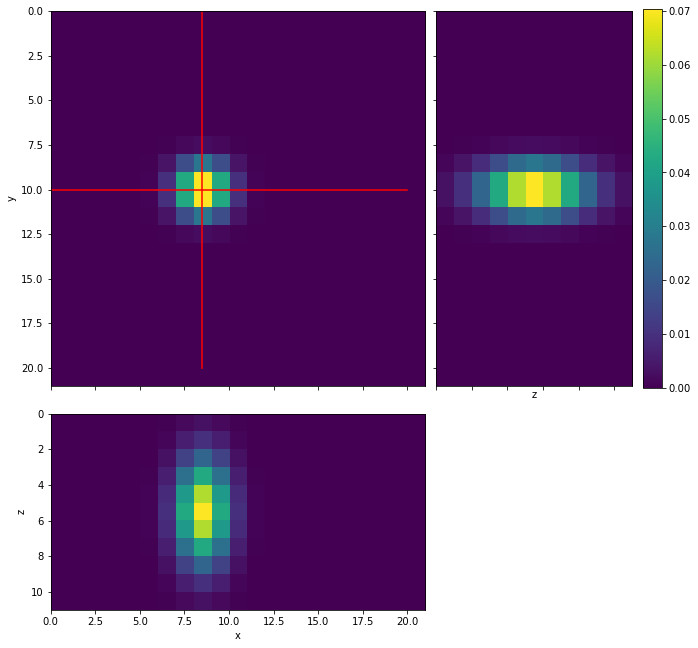

In [ ]:
from decode_fish.funcs.plotting import plot_3d_projections
shift_xyz = torch.tensor([-2,0.,+2,0.]).cuda(),torch.tensor([-.5,0.,0.,0.]).cuda(),torch.tensor([0.,0.,0.,0.]).cuda()
# shifted_psf_bl = psf(shift_xyz[0],shift_xyz[1],shift_xyz[2], [7,6,4,2]) # Treat as slice
shifted_psf_bl = psf(shift_xyz[0],shift_xyz[1],shift_xyz[2]) # Treat as volume
# First output is the volume_shifted_psf_bl 2 pixels to the left.
fig, ax = plot_3d_projections(cpu(shifted_psf_bl)[0,0])
ax[0].plot([10.5+shift_xyz[0][0],10.5+shift_xyz[0][0]],[0,20], 'red') 
ax[0].plot([0,20], [10.5+shift_xyz[1][0],10.5+shift_xyz[1][0]], 'red')
shifted_psf_bl.shape

In [ ]:
# export 
def PSFloader(psf_file=None, gauss_radii=[1.,1.,1.], psf_extent_zyx=[13,13,13], n_cols=1, mode='bicubic', device='gpu'):
    
    if psf_file:
        psf_vol = load_tiff_image(psf_file)
    else:
        psf_vol = gaussian_sphere(psf_extent_zyx, gauss_radii)
        
    return LinearInterpolatedPSF(psf_vol, n_cols=n_cols, device=device, mode=mode)

In [ ]:
size_zyx = [1,21,21]

vol_3d = []
facs = np.linspace(0.7,2.,11)
for i in range(len(facs)):
    
    s = gaussian_sphere(size_zyx, [1.7,1.7*facs[i],1.7*facs[i]], [size_zyx[0]//2,size_zyx[1]//2,size_zyx[2]//2])
    vol_3d.append(s)
    
vol_3d = np.concatenate(vol_3d,0)
vol_3d /= vol_3d[0].sum(-1).sum(-1)

In [ ]:
vol_3d.sum(-1).sum(-1)

array([1.        , 1.        , 1.        , 0.99999998, 0.99999936,
       0.99999198, 0.99994674, 0.99977095, 0.99927674, 0.99817802,
       0.99612515])

(<Figure size 701.486x658.286 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

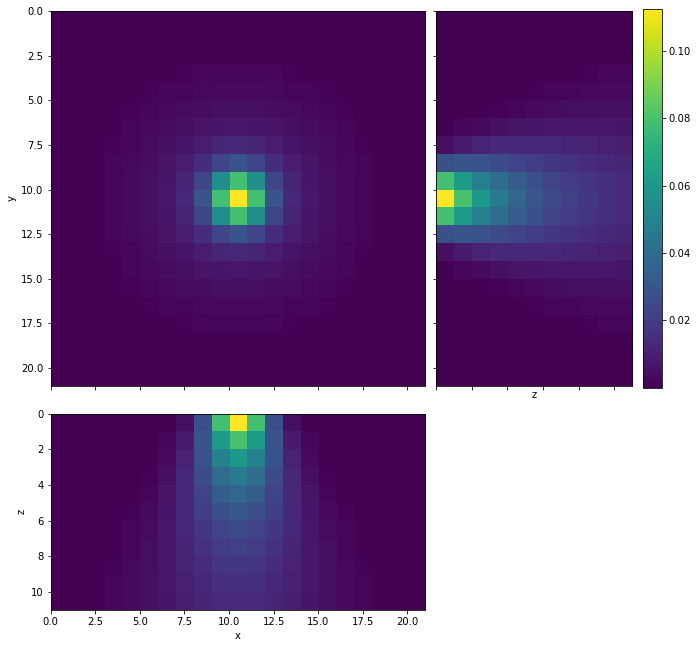

In [ ]:
from decode_fish.funcs.plotting import plot_3d_projections
plot_3d_projections(vol_3d)

In [ ]:
# import tifffile
# tifffile.imsave('../figures/MF_psf_07_20n.tif', data=vol_3d)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_matching.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
